# Soft Actor-Critic

This notebooks runs different test trials of the fully recurrent version of the Soft Actor-Critic. The test are run on the straight line stabilization tasks.

### Import libraries

In [1]:
import jax
import jax.numpy as jnp
import jax.random as jrandom

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import clear_output
import matplotlib.animation as animation
from matplotlib.gridspec import GridSpec
import pickle

# import local libraries
from environments.linear import Linear_SDI
from environments.orbit import Orbital_SDI
from src.SoftActorCritic.main import SACAgent


### Utilities

In [2]:
def run_trial(
    key,
    env,
    controller,
    T,
    x0 = None,
    n_obs = 2,
    hidden_size=8
):
    t_space = np.arange(0, T, env.dt)

    Y = np.zeros((len(t_space), n_obs))
    S = np.zeros((len(t_space), n_obs))
    U = np.zeros((len(t_space), 1))

    y = env.reset(x0)
    u = 0
    hid = jnp.zeros(hidden_size)
    for idx, t in enumerate(np.arange(0, T, env.dt)):
        u, hid = controller.predict_step(y, u, hid)
        #u, _, hid = controller.forward_step(y, u, hid, key)
        y, rew, done, _ = env.step(u, key=key)
        Y[idx] = y
        S[idx] = env.state
        U[idx] = u

        key, _ = jrandom.split(key)
    
    return S, Y, U


## SAC - fully observable

Instance of the stochastic double integrator with full observability.

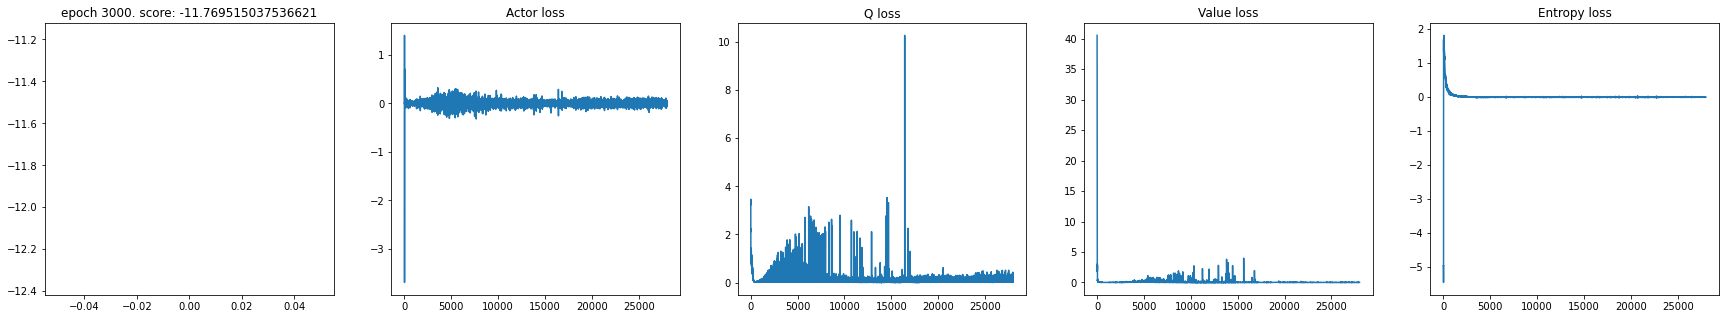

In [3]:
# PARAMETERS
gamma = 1

memory_size = 2200
batch_size = 128
initial_random_steps = 200

control_limit = 4.
state_scale = 5
obs_size = 2
ctrl_size = 1

n_trials = 4
Nep = 3000
name = 'SAC'
PARAMS = {name:[]}

for idx in range(n_trials):
    PARAMS[name] += [{}]

    np.random.seed(idx)
    key = jrandom.PRNGKey(idx)

    env = Linear_SDI(end_time=20)
    env.v = jnp.identity(2) * 0
    env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        lr_q=1e-3,
        memory_decay=5e-3,
        gamma=gamma
    )
    
    for factor in range(1, int(Nep/200)+1):
        agent.train(200, key, plotting_interval=200, record=True)

        PARAMS[name][idx][f'N{factor*200}'] = {'pi': agent.actor.model,
                                                    'q1': agent.QF1.model,
                                                    'q2': agent.QF2.model,
                                                    'v': agent.VF.model,
                                                    'vt': agent.VF_target.model}

In [4]:
# with open(f'models/0331/SACRNN_OO_fully_observable.pickle', 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Results

In [5]:
env = Linear_SDI(end_time=20)
env.v = jnp.identity(2) * 0
env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

N = 10

x_space = np.linspace(-10, 10, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

agent = PARAMS[name][0]
for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

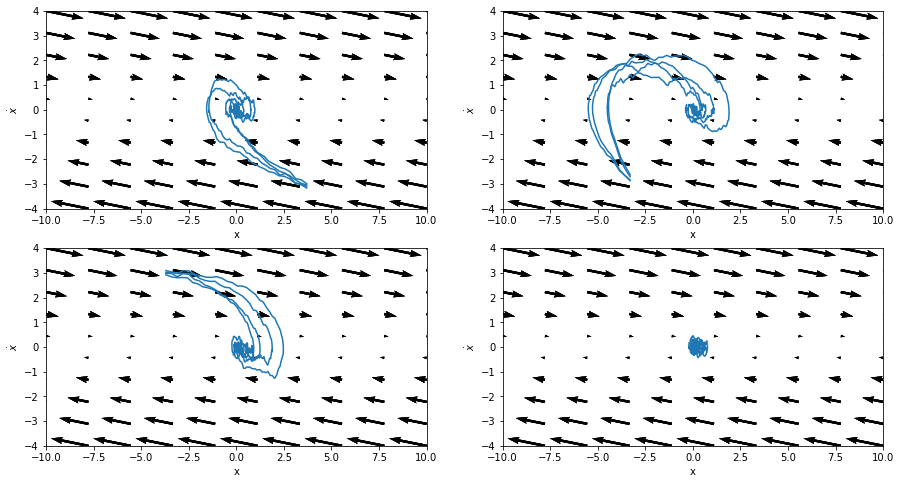

In [6]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for idx in range(n_trials):
    controller = PARAMS[name][idx][f'N{Nep}']['pi']
    for pidx in range(4):
        S, Y, U = run_trial(key, env, controller, 15, x0=x0[pidx], hidden_size=hidden_size)
        ax[pidx].quiver(xv, vv, qx, qv)
        ax[pidx].plot(S[:,0], S[:,1], c='tab:blue')

for idx in range(4):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
plt.show()

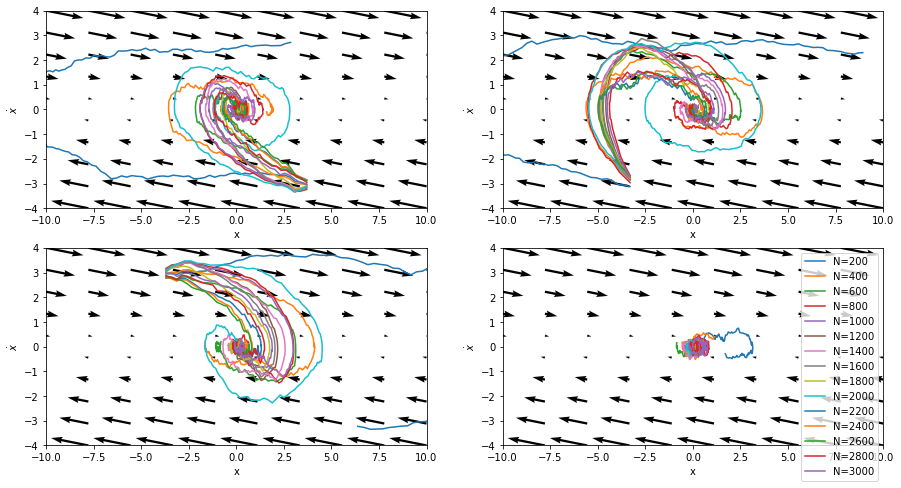

In [7]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for factor in range(1, int(Nep/200)+1):
    controller = PARAMS[name][0][f'N{factor*200}']['pi']
    for pidx in range(4):
        S, Y, _ = run_trial(key, env, controller, 15, x0=x0[pidx], hidden_size=hidden_size)        
        ax[pidx].plot(S[:,0], S[:,1], label=f'N={factor*200}')

for idx in range(4):
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
ax[-1].legend()
plt.show()

## SAC - partial observability

Now the effect of noisy observations is tested. The system is run and tested under different noise levels.

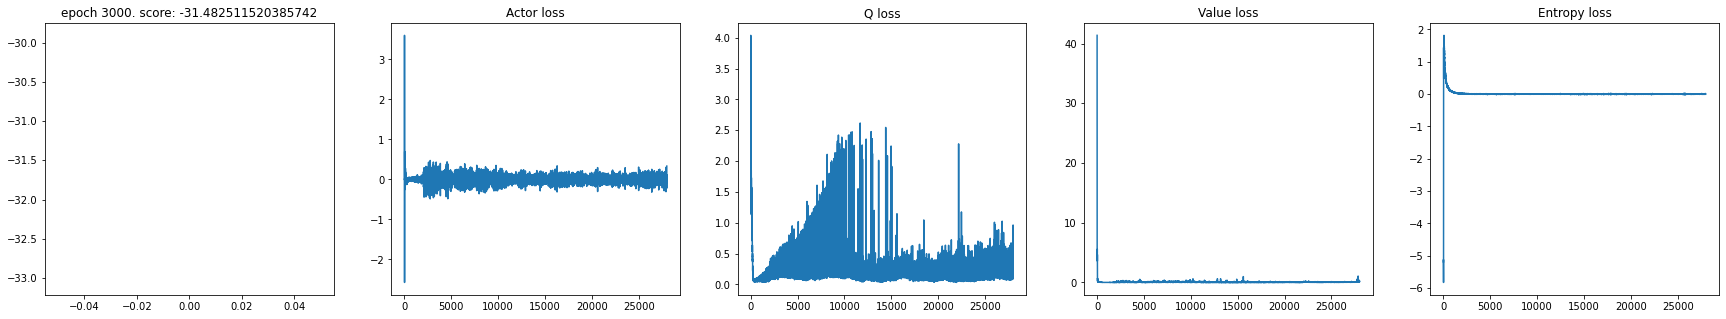

In [8]:
# PARAMETERS
gamma = 1

memory_size = 2200
batch_size = 128
initial_random_steps = 200

control_limit = 4.
state_scale = 5
obs_size = 2
ctrl_size = 1

n_trials = 4
Nep = 3000
name = 'SAC_PO'
PARAMS = {name:[]}

for idx in range(n_trials):
    PARAMS[name] += [{}]

    np.random.seed(0)
    key = jrandom.PRNGKey(0)

    env = Linear_SDI(end_time=20)
    env.v = jnp.identity(2) * idx/10
    env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        lr_q=1e-3,
        memory_decay=5e-3,
        gamma=gamma
    )
    
    for factor in range(1, int(Nep/200)+1):
        agent.train(200, key, plotting_interval=200, record=True)

        PARAMS[name][idx][f'N{factor*200}'] = {'pi': agent.actor.model,
                                                    'q1': agent.QF1.model,
                                                    'q2': agent.QF2.model,
                                                    'v': agent.VF.model,
                                                    'vt': agent.VF_target.model}


In [9]:
# import pickle
# with open(f'models/0331/SACRNN_OO_partially_observable.pickle', 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Results

In [17]:
state_scale = 5

env = Linear_SDI(end_time=20)
env.v = jnp.identity(2) * 0
env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

N = 10

x_space = np.linspace(-10, 10, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

agent = PARAMS[name][0]
for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

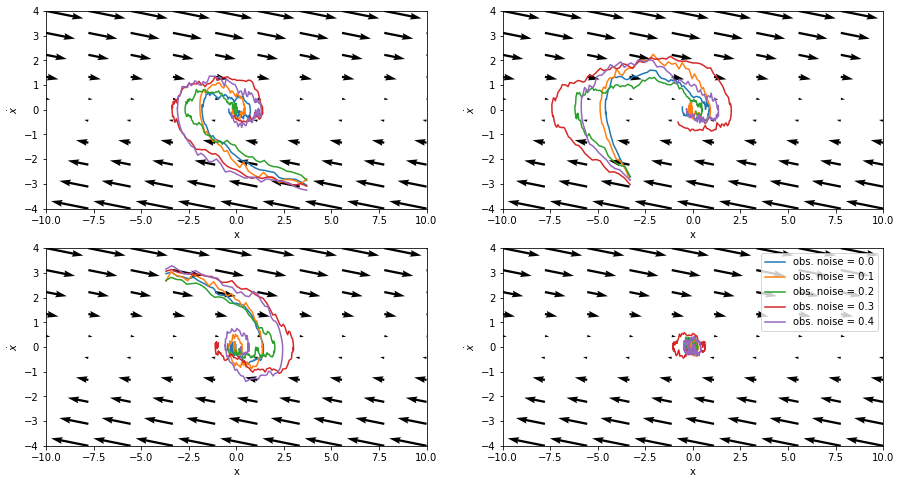

In [18]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for idx in range(n_trials):
    controller = PARAMS[name][idx][f'N{Nep}']['pi']
    for pidx in range(4):
        env.v = jnp.identity(2) * idx/10
        S, Y, _ = run_trial(key, env, controller, 15, x0=x0[pidx], hidden_size=hidden_size)
        ax[pidx].plot(S[:,0], S[:,1], label=f'obs. noise = {idx/10:.1f}')

for idx in range(4):
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
ax[-1].legend()
plt.show()

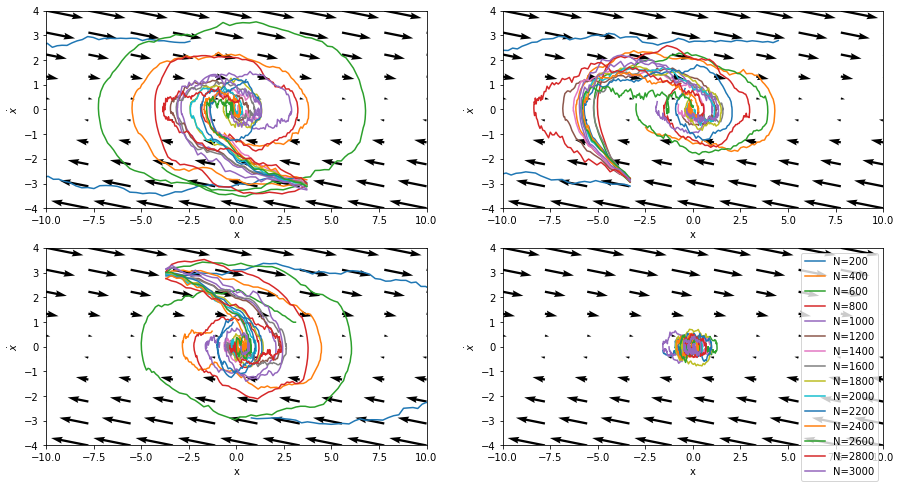

In [19]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for factor in range(1, int(Nep/200)+1):
    controller = PARAMS[name][-1][f'N{factor*200}']['pi']
    for pidx in range(4):
        env.v = jnp.identity(2) * .4
        S, Y, _ = run_trial(key, env, controller, 15, x0=x0[pidx], hidden_size=hidden_size)        
        ax[pidx].plot(S[:,0], S[:,1], label=f'N={factor*200}')

for idx in range(4):
    ax[idx].quiver(xv, vv, qx, qv)
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
ax[-1].legend()
plt.show()

## SAC - GRU - partial observability

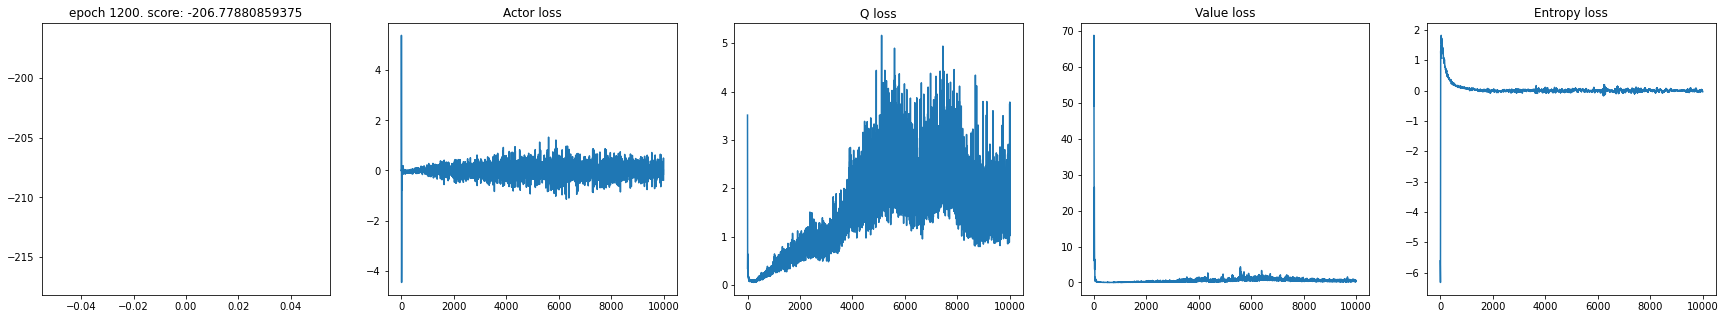

In [5]:
# PARAMETERS
memory_size = 1000
batch_size = 128
initial_random_steps = 200

history_size = 8
control_limit = 4.
state_scale = 5
obs_size = 2
ctrl_size = 1

n_trials = 5
Nep = 1200
name = 'SAC_GRU'
PARAMS = {name:[]}

for idx in range(n_trials):
    PARAMS[name] += [{}]

    np.random.seed(0)
    key = jrandom.PRNGKey(0)

    env = Linear_SDI(end_time=20)
    env.v = jnp.identity(2) * idx/10
    env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=10,
        lr=1e-2,
        memory_decay=5e-3,
        history_size=history_size,
        recurrence='GRU'
    )
    
    for factor in range(1, int(Nep/200)+1):
        agent.train(200, key, plotting_interval=200, record=True)

        PARAMS[name][idx][f'N{factor*200}'] = {'pi': agent.actor.model,
                                                    'q1': agent.QF1.model,
                                                    'q2': agent.QF2.model,
                                                    'v': agent.VF.model,
                                                    'vt': agent.VF_target.model}


In [6]:
# import pickle
# with open(f'models/SACRNN_OO/partial_observability_GRU.pickle', 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Results

In [7]:
state_scale = 5

env = Linear_SDI(end_time=20)
env.v = jnp.identity(2) * 0
env._set_boundary(boundary = True, min = -jnp.ones(2)*state_scale, max = jnp.ones(2)*state_scale)

N = 10

x_space = np.linspace(-10, 10, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

agent = PARAMS[name][0]
for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

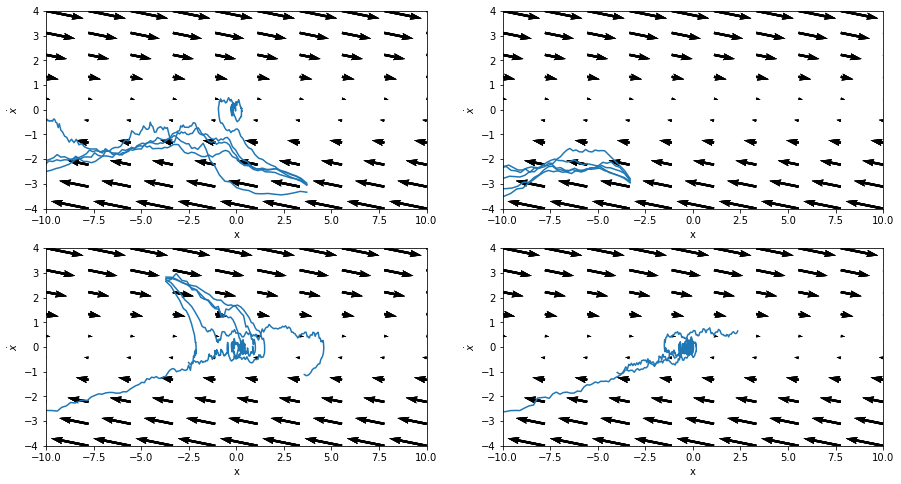

In [8]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for idx in range(n_trials):
    controller = PARAMS[name][idx][f'N{Nep}']['pi']
    for pidx in range(4):
        S, Y = run_trial(key, env, controller, 15, x0=x0[pidx])
        ax[pidx].quiver(xv, vv, qx, qv)
        ax[pidx].plot(S[:,0], S[:,1], c='tab:blue')

for idx in range(4):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
plt.show()

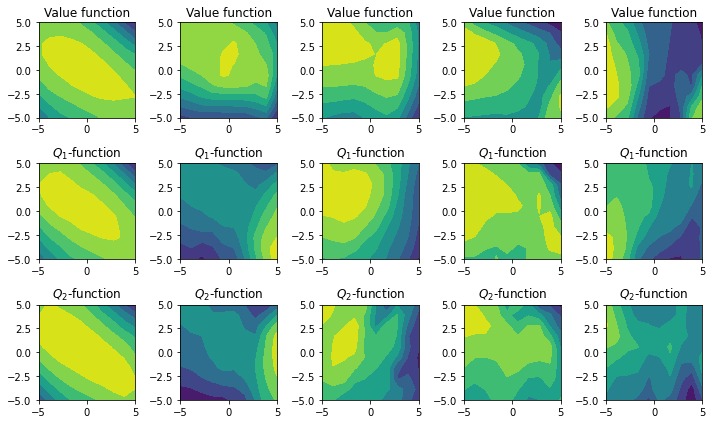

In [9]:
N = 10

x_space = np.linspace(-5, 5, N)
v_space = np.linspace(-5, 5, N)
xvi, vvi = np.meshgrid(x_space, v_space)

fig, ax = plt.subplots(3, n_trials, figsize=(10, 6))

for trial in range(n_trials):
    V = np.zeros((N,N))
    Q1 = np.zeros((N, N))
    Q2 = np.zeros((N, N))

    vf = PARAMS[name][trial][f'N{Nep}']['v']
    q1 = PARAMS[name][trial][f'N{Nep}']['q1']
    q2 = PARAMS[name][trial][f'N{Nep}']['q2']

    for i, x in enumerate(x_space):
        for j, v in enumerate(v_space):
            state = jnp.array([x, v]) / state_scale
            V[i, j] = vf(state)
            Q1[i, j] = q1(state, 0)
            Q2[i, j] = q2(state, 0)

    ax[0, trial].contourf(xvi, vvi, V)
    ax[0, trial].set_title('Value function')

    ax[1, trial].contourf(xvi, vvi, Q1)
    ax[1, trial].set_title(r'$Q_1$-function')

    ax[2, trial].contourf(xvi, vvi, Q2)
    ax[2, trial].set_title(r'$Q_2$-function')

plt.tight_layout()
plt.show()

## SAC (WC) - Orbital particle

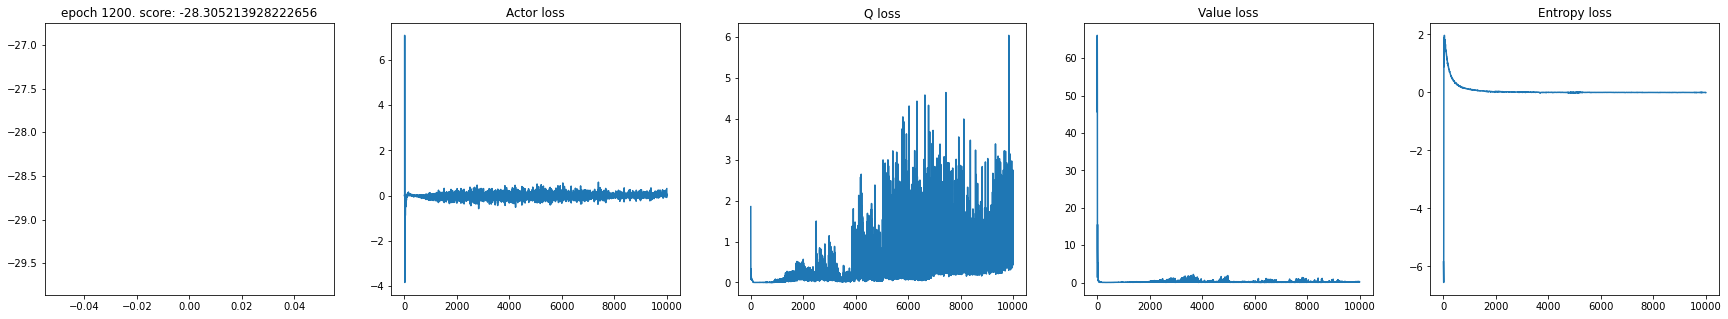

In [3]:
# PARAMETERS
memory_size = 2000
batch_size = 128
initial_random_steps = 200

hidden_size = 8
history_size = 12
control_limit = 1
state_scale = 5
obs_size = 2
ctrl_size = 1

n_trials = 1
Nep = 4000
name = 'SAC_WC'
PARAMS = {name:[]}

for idx in range(n_trials):
    PARAMS[name] += [{}]

    np.random.seed(0)
    key = jrandom.PRNGKey(0)

    env = Linear_SDI(end_time=10)
    env.v = jnp.identity(2) * 0
    env._set_boundary(boundary=True, min=-jnp.ones(2)*state_scale, max=jnp.ones(2)*state_scale)

    agent = SACAgent(
        env, memory_size, key, 
        initial_random_steps=initial_random_steps, 
        obs_size=obs_size, 
        ctrl_size=ctrl_size,
        control_limit=control_limit,
        epochs_per_step=5,
        lr=1e-2,
        memory_decay=5e-3,
        history_size=history_size,
        hidden_size=hidden_size,
        recurrence='WC'
    )
    
    for factor in range(1, int(Nep/200)+1):
        agent.train(200, key, plotting_interval=200, record=True)

        PARAMS[name][idx][f'N{factor*200}'] = {'pi': agent.actor.model,
                                                    'q1': agent.QF1.model,
                                                    'q2': agent.QF2.model,
                                                    'v': agent.VF.model,
                                                    'vt': agent.VF_target.model}

In [ ]:
# import pickle
# with open(f'models/SACRNN_OO/fully_recurrent_orbital.pickle', 'wb') as handle:
#     pickle.dump(PARAMS, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Results

In [16]:
state_scale = 5

env = Linear_SDI(end_time=10)
env.v = jnp.identity(2) * 0
#env._set_boundary(boundary=True, min=-jnp.ones(2)*state_scale, max=jnp.ones(2)*state_scale)

N = 10

x_space = np.linspace(-10, 10, N)
v_space = np.linspace(-4, 4, N)
xv, vv = np.meshgrid(x_space, v_space)
qx = np.zeros((N,N))
qv = np.zeros((N,N))

agent = PARAMS[name][0]
for i, x in enumerate(x_space):
  for j, v in enumerate(v_space):
    state = jnp.array([xv[i,j], vv[i,j]])
    dx, dv = env.predict_deriv(state, 0)
    qx[i,j] = dx
    qv[i,j] = dv

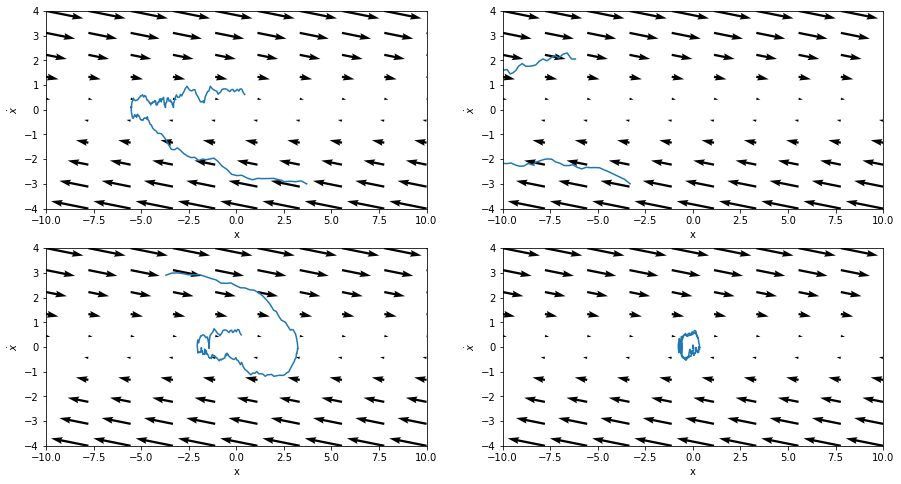

In [32]:
x0 = [jnp.array([4, -3]), jnp.array([-3, -3]), jnp.array([-4, 3]), jnp.array([0, 0])]

fig, ax = plt.subplots(2, 2, figsize=(15, 8))
ax = ax.flatten()

for idx in range(n_trials):
    controller = PARAMS[name][idx][f'N{Nep}']['pi']
    for pidx in range(4):
        S, Y, U = run_trial(key, env, controller, 20, x0=x0[pidx], hidden_size=hidden_size)
        ax[pidx].quiver(xv, vv, qx, qv)
        ax[pidx].plot(S[:,0], S[:,1], c='tab:blue')

for idx in range(4):
    ax[idx].set_xlabel('x')
    ax[idx].set_ylabel(r'$\dot{x}$')
    ax[idx].set_xlim([-10, 10])
    ax[idx].set_ylim([-4, 4])
plt.show()

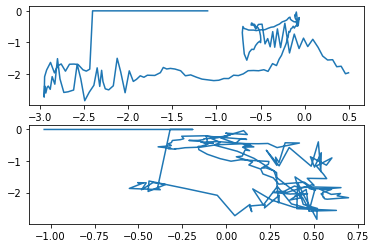

In [56]:
vf = PARAMS[name][0][f'N{factor*200}']['vt']

S, Y, U = run_trial(key, env, controller, 20, x0=jnp.array([-1, -1]), hidden_size=hidden_size)
fig, ax = plt.subplots(2)


V = np.zeros(200)
for num in range(200):
    V[num] = vf(S[num-20:num], U[num-20:num])

ax[0].plot(S[:,0], V, c='tab:blue')
ax[1].plot(S[:,1], V, c='tab:blue')


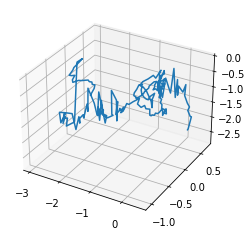

In [53]:
import numpy as np
import matplotlib.pyplot as plt

ax = plt.figure().add_subplot(projection='3d')

# Plot a sin curve using the x and y axes.
x = np.linspace(0, 1, 100)
y = np.sin(x * 2 * np.pi) / 2 + 0.5
ax.plot(S[:,0], S[:,1], zs=V, zdir='z', label='curve in (x, y)')


plt.show()

In [51]:
Z.shape

(120, 120)